In [1]:
import os
import numpy
import pathlib
import toml
import matplotlib
from matplotlib import pyplot
import xarray
import scipy.stats
from glob import glob

In [2]:
def load_array(paths):
    result = []
    for path in paths:
        array = numpy.loadtxt(path, ndmin=2)
        if array.size != 0:
            result.append(array)
    return numpy.concatenate(result)

In [8]:
def load_clean(file):
    try:
        ds = xarray.open_dataset(file)
        try:
            ds = ds.rename_dims(ce_num_signals='ce', me_num_responses='me')
        except ValueError:
            pass
    except Exception as e:
        ds = None
        print(str(e))
        pass
    return ds

def load_run_nc(name):
    path = f"../runs/{name}/*/"
    
    conf = toml.load(f"../runs/{name}/configuration.toml")
    data = []
    for file in glob(path + 'data.nc'):
        ds = load_clean(file)
        if ds is not None:
            data.append(ds)
        
    me = [ds.drop_dims('ce') for ds in data]
    ce = [ds.drop_dims('me') for ds in data]
    me = xarray.concat(me, dim='me', data_vars="minimal")#, compat="identical")
    ce = xarray.concat(ce, dim='ce', data_vars="minimal")#, compat="identical")
    ds = xarray.merge([me, ce])
    ds['mutual_information'] = ds['marginal_entropy'].mean('me') - ds['conditional_entropy'].mean('ce')
    ds['mutual_information'].attrs['unit'] = 'nats'
    ds.attrs = data[0].attrs
    for (key, value) in ds.items():
        try:
            value.attrs = data[0][key].attrs
        except KeyError:
            pass
    return ds

In [38]:
def load_run(i):
    path = f"../runs/testrun{i}/*/"
    
    ce = load_array(glob(path + 'conditional_entropy.txt'))
    me = load_array(glob(path + 'marginal_entropy.txt'))
    conf = toml.load(f"../runs/testrun{i}/configuration.toml")
    tl = numpy.linspace(0.0, conf['length'], conf['num_trajectory_lengths'])
    
    ds = xarray.Dataset({'conditional_entropy': (['ce_num_signals', 'time'], ce),
                         'marginal_entropy': (['me_num_responses', 'time'], me)},
                        coords = {'time': tl})
    
    ds["marginal_entropy"].attrs["num_signals"] =  conf["marginal_entropy"]["num_signals"]
    ds["conditional_entropy"].attrs["responses_per_signal"] =  conf["conditional_entropy"]["responses_per_signal"]

    ds['mutual_information'] = ds['marginal_entropy'].mean('me', skipna=True) - ds['conditional_entropy'].mean('ce', skipna=True)
    ds.to_netcdf(f"../runs/testrun{i}/cache.nc")
    return ds

def get_run(i):
    return xarray.open_dataset(f"../runs/testrun{i}/cache.nc")
    
def plot_run(ds, neg=False, **args):
    tl = ds['time'].data
    if neg:
        mi = -ds['mutual_information'].data
    else:
        mi = ds['mutual_information'].data
    pyplot.plot(tl, mi, **args)

In [5]:
# ds = get_run(20)

In [6]:
num_tl, num_mi = (numpy.array([  3.2       ,   4.75518173,   7.06617289,  10.50029256,
         15.60337477,  23.18652581,  34.45504493,  51.2       ,
         76.0829076 , 113.0587662 , 168.00468091, 249.65399638,
        370.98441288, 551.2807189 , 819.2       ]),
 numpy.array([0.16057347, 0.16313811, 0.16753439, 0.17376199, 0.18328551,
        0.19683625, 0.21770779, 0.24809272, 0.29384163, 0.36153363,
        0.46213797, 0.61138198, 0.83304402, 1.1629737 , 1.65274695]))

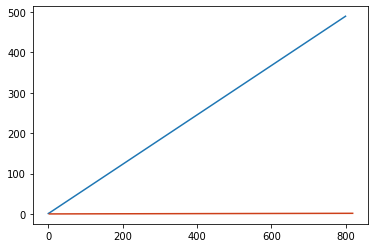

In [9]:
# plot_run(load_run_nc("long_N50k_M200k"))
plot_run(load_run_nc("long_200k"))
pyplot.plot(num_tl, num_mi, color='#CD401A', label="analytial slope")

In [50]:
run = "medium_20k_2"
# ds = get_run(run)
ds = load_run_nc(run).dropna('ce', how='all').dropna('me', how='all')
error_me = scipy.stats.sem(ds['marginal_entropy'], nan_policy='omit')
error_ce = scipy.stats.sem(ds['conditional_entropy'], nan_policy='omit')
ds

[Errno -101] NetCDF: HDF error: b'/home/ipausers/reinhardt/runs/medium_20k_2/481[1].head.hollandia.amolf.nl/data.nc'


<xarray.Dataset>
Dimensions:                     (ce: 297000, me: 297000, time: 400)
Coordinates:
  * time                        (time) float64 0.0 1.253 2.506 ... 498.7 500.0
Dimensions without coordinates: ce, me
Data variables:
    marginal_entropy            (me, time) float64 -3.801 -5.206 ... -850.8
    marginal_entropy_err        (me, time) float64 0.003922 0.003634 ... 0.01651
    marginal_entropy_timing     (me) float64 1.74 1.653 1.52 ... 1.333 1.603
    conditional_entropy         (ce, time) float64 -3.526 -4.978 ... -737.9
    conditional_entropy_err     (ce, time) float64 0.005497 0.00951 ... 0.1822
    conditional_entropy_timing  (ce) float64 4.695 4.541 4.303 ... 4.361 3.809
    mutual_information          (time) float64 -0.1404 -0.1428 ... -1.741 -1.744
Attributes:
    creator_email:  reinhardt@amolf.nl
    creator_name:   Manuel Reinhardt
    description:    A medium run with N=M=20_000.
    institution:    AMOLF, Amsterdam, NL
    title:          Simulation results for mutual information between two tra...
    source:         `accelerate` (version 0.2.0, commit f0253c37b210259e1a5b0...
    date_modified:  2020-01-28T14:11:45.027224501+01:00
    p0_samples:     500

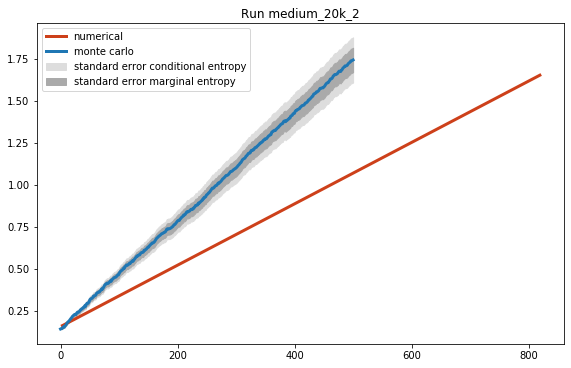

In [52]:
tl = ds['time'].data
mi = -ds['mutual_information'].data
pyplot.fill_between(tl, mi+error_me+error_ce, mi-error_me-error_ce, color="#DDDDDD", label="standard error conditional entropy")
pyplot.fill_between(tl, mi+error_me, mi-error_me, alpha=1, color="#AAAAAA", label="standard error marginal entropy")
pyplot.plot(num_tl, num_mi, color='#CD401A', label="numerical", linewidth=3);
pyplot.plot(tl, mi, label="monte carlo", linewidth=3)
pyplot.legend()
if False:
    pyplot.xscale('log')
    pyplot.yscale('log')
pyplot.title(f"Run {run}")
pyplot.gcf().set_size_inches(24/2.54, 15/2.54)
pyplot.savefig('errorbars.pdf')

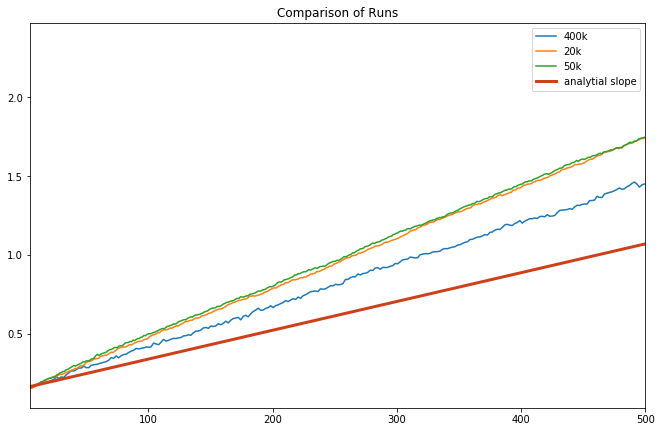

In [55]:
plot_run(load_run_nc("verylong_400k"), neg=True, label='400k')
plot_run(load_run_nc("medium_20k_2"), neg=True, label='20k')
plot_run(load_run_nc("medium_50k_2"), neg=True, label='50k')
pyplot.plot(num_tl, num_mi, color='#CD401A', label="analytial slope", linewidth=3)
pyplot.title("Comparison of Runs")
pyplot.gcf().set_size_inches(28/2.54, 18/2.54)
pyplot.legend();
pyplot.xlim(5, 500)
if False:
    pyplot.xscale('log')
    pyplot.yscale('log')
pyplot.savefig('runs.pdf')

0.41245202693899363

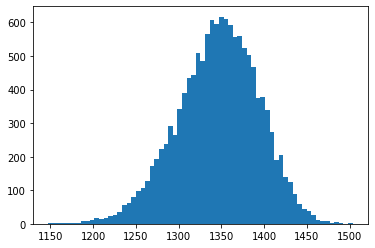

In [49]:
x = ce[:, 1999]
pyplot.hist(x, bins='auto')
scipy.stats.sem(x)

In [139]:
scipy.stats.sem(me)[:10], scipy.stats.sem(ce)[:10]

(array([0.        , 0.00672183, 0.01064141, 0.01399801, 0.01674254,
        0.01903048, 0.02079663, 0.02233547, 0.02364561, 0.02487028]),
 array([0.00000000e+00, 5.28494332e-05, 3.68496866e-04, 8.83063270e-04,
        1.47421038e-03, 2.08989002e-03, 2.70705116e-03, 3.31453604e-03,
        3.90686546e-03, 4.48686129e-03]))

In [47]:
ce.shape

(1000, 1000)